<a href="https://colab.research.google.com/github/BeamlakTamirat/DS/blob/main/LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.3 MB/s eta 0:00:00


In [2]:
!pip install kagglehub

In [3]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
path  = kagglehub.dataset_download('elikplim/car-evaluation-data-set')

In [5]:
df = pd.read_csv(path + '/car_evaluation.csv', header=None)

In [ ]:
df.head()


,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [7]:
col_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
df.columns = col_names
col_names


['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [9]:
col_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
for col in col_names:
    print(df[col].value_counts())

buying
vhigh    432
high     432
med      432
low      432
Name: count, dtype: int64
maint
vhigh    432
high     432
med      432
low      432
Name: count, dtype: int64
doors
2        432
3        432
4        432
5more    432
Name: count, dtype: int64
persons
2       576
4       576
more    576
Name: count, dtype: int64
lug_boot
small    576
med      576
big      576
Name: count, dtype: int64
safety
low     576
med     576
high    576
Name: count, dtype: int64
class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64


## Encode

In [10]:
import category_encoders as ce
# encode categorical variables with ordinal encoding
encoder = ce.OrdinalEncoder(cols=df.select_dtypes(include='object'))
df = encoder.fit_transform(df)

## Split

In [11]:
X = df.drop(columns=['class'], axis=1)
y = df['class']

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Over Sampling

In [13]:
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler()
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (3900, 6)


,buying,maint,doors,persons,lug_boot,safety
0,1,1,4,3,3,3
1,3,1,2,2,1,2
2,4,4,4,1,3,3
3,2,3,3,1,2,2
4,2,3,2,1,2,1


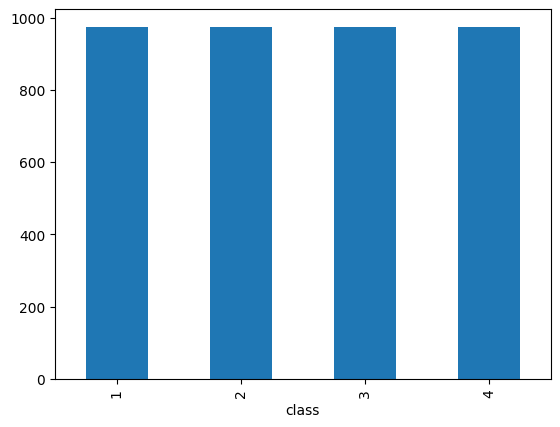

In [14]:
y_train_over.value_counts().plot(kind='bar');

## Hyperparameter tuning and Cross Validation

In [15]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 18.6 MB/s eta 0:00:00


In [16]:
import lightgbm as lgb
import optuna
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.model_selection import cross_val_score
# Optional: Ensure reproducibility
RANDOM_STATE = 42

# Define the Optuna objective function
def objective(trial):
    param = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1]),
        'max_depth': trial.suggest_categorical('max_depth', [3, 4, 5]),
        'subsample': trial.suggest_categorical('subsample', [0.8, 1.0]),
        'min_split_gain': trial.suggest_categorical('min_split_gain', [0.0, 0.1]),  # LightGBM equivalent to min_samples_split logic
        'random_state': RANDOM_STATE
    }

    clf = lgb.LGBMClassifier(**param)
    score = cross_val_score(clf, X_train_over, y_train_over, cv=5, scoring='accuracy', n_jobs=-1)
    return score.mean()

# Run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=600)  # You can adjust `n_trials` or `timeout`

# Train final model with best params
best_params = study.best_params
best_params['random_state'] = RANDOM_STATE

[I 2025-05-02 19:06:17,452] A new study created in memory with name: no-name-8b1f8c8d-ea56-401c-9e17-4794af9022ca
[I 2025-05-02 19:06:31,586] Trial 0 finished with value: 0.8956410256410257 and parameters: {'n_estimators': 200, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 1.0, 'min_split_gain': 0.0}. Best is trial 0 with value: 0.8956410256410257.
[I 2025-05-02 19:06:37,665] Trial 1 finished with value: 0.9646153846153845 and parameters: {'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 4, 'subsample': 1.0, 'min_split_gain': 0.0}. Best is trial 1 with value: 0.9646153846153845.
[I 2025-05-02 19:06:42,092] Trial 2 finished with value: 0.9961538461538462 and parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 5, 'subsample': 1.0, 'min_split_gain': 0.1}. Best is trial 2 with value: 0.9961538461538462.
[I 2025-05-02 19:06:46,321] Trial 3 finished with value: 0.9907692307692308 and parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 3, 'sub

In [ ]:
from sklearn.metrics import accuracy_score

# Train final model with best params
best_model = lgb.LGBMClassifier(**best_params)
best_model.fit(X_train_over, y_train_over)

# Evaluate
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [ ]:
print("Best Parameters:", best_params)
print("Test Accuracy:", accuracy)

In [ ]:
features = X_train.columns

# Extract feature importances from the trained best LightGBM model
importances = best_model.feature_importances_

# Create a Pandas Series with feature names and importances
feat_imp = pd.Series(importances, index=features).sort_values(ascending=True)

# Plot the 10 most important features
feat_imp.tail(10).plot(kind='barh')  # Only top 10
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (LightGBM + Optuna)")
plt.tight_layout()
plt.show()